In [ ]:
using Pkg
Pkg.activate("/usr/local/bin/SLIM-tutorials/02-normalizing-flows")
Pkg.instantiate()

# Conditional Normalizing Flow Posterior Sampling and Training

This notebook demonstrates the use of Conditional Glow networks for sampling from a posterior distribution and training on masked MNIST data. 

Although an extremetely simple case it contains the same machinery that we use for WISE and ASPIRE for amortized conditional sampling. 

In [1]:
using InvertibleNetworks
using Flux
using LinearAlgebra
using MLDatasets
using ImageTransformations
using MLUtils
using ProgressMeter: Progress, next!
using Statistics
using PyPlot
using Random

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt ~/.julia/packages/Flux/vwk6M/ext/FluxCUDAExt/FluxCUDAExt.jl:10


## Load and Preprocess MNIST Data
We will load the MNIST dataset and resize it to smaller dimensions (16x16) for faster training. This should train for 2-3 minutes on a CPU. 


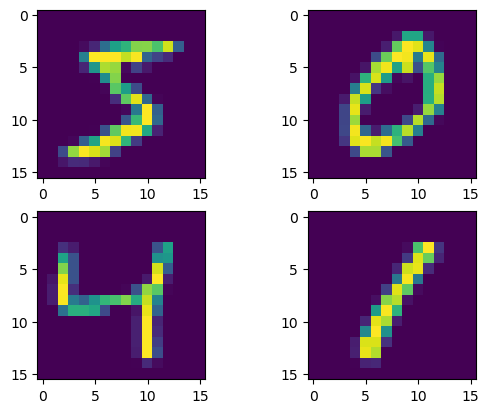

PyObject <matplotlib.image.AxesImage object at 0x16b72e290>

In [2]:
# Training data parameters
n_total = 2048 # Total number of samples

# Load the MNIST dataset and select only the first `n_total` samples
X, _ = MNIST(split=:train)[1:n_total];

# Resize images to 16x16 to simplify training
nx, ny = 16, 16
N = nx*ny
Xs = zeros(Float32, nx, ny, 1, n_total)

for i in 1:n_total
    Xs[:,:,:,i] = imresize(X[:,:,i]', (nx, ny))
end


figure()
subplot(2,2,1)
imshow(Xs[:,:,:,1])
subplot(2,2,2)
imshow(Xs[:,:,:,2])
subplot(2,2,3)
imshow(Xs[:,:,:,3])
subplot(2,2,4)
imshow(Xs[:,:,:,4])


## Create Masking (Forward) Operator
Define a masking operator that sets the center of each image to zero. In the simulation-based inference framework, this represents your forward simulation that takes you from the unknown to the observation. 


In [3]:
mask_size = 3
mask_start = div((nx - mask_size), 2)

A = ones(Float32, nx, ny)
A[mask_start:(end-mask_start), mask_start:(end-mask_start)] .= 0f0;

## Simulate corrupted observations with the forward operator


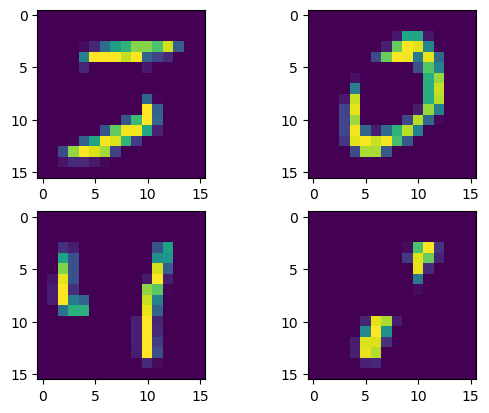

PyObject <matplotlib.image.AxesImage object at 0x28dcf2a70>

In [4]:
Ys = A .* Xs;
figure()
subplot(2,2,1)
imshow(Ys[:,:,:,1])
subplot(2,2,2)
imshow(Ys[:,:,:,2])
subplot(2,2,3)
imshow(Ys[:,:,:,3])
subplot(2,2,4)
imshow(Ys[:,:,:,4])

## Split Data into Training and Validation Sets
We'll split the dataset into training and validation sets using `MLUtils`. Here we use a 90% split for training. 


In [5]:
Random.seed!(1234)
validation_perc = 0.9 # Percentage of data used for training
XY_train, XY_val = splitobs((Xs, Ys); at=validation_perc, shuffle=true)
train_loader = DataLoader(XY_train, batchsize=128, shuffle=true, partial=false);

# Number of training batches 
n_train  = numobs(XY_train)
n_val    = numobs(XY_val)


205

## Define the Conditional Glow Model
Create a Conditional Glow model with the `InvertibleNetworks` package.


In [18]:
# Training hyperparameters
device = cpu #GPU does not accelerate at this small size. quicker on cpu
lr     = 2f-3
epochs = 60
batch_size = 128
batches  = cld(n_train, batch_size)

15

In [19]:
chan_x, chan_y = 1, 1
L = 2
K = 10
n_hidden = 32
G = NetworkConditionalGlow(chan_x, chan_y, n_hidden, L, K; split_scales=true) |> device

NetworkConditionalGlow

## Train the Model
Train the conditional normalizing flow by minimizing the negative log-likelihood of the target variable conditioned by the observation.


In [20]:
opt = Adam(lr)
loss_train, loss_val = [], []
progress = Progress(epochs * length(train_loader))

for e=1:epochs # epoch loop
    for (X, Y) in train_loader #batch loop
        ZX, ZY, logdet_i = G.forward(X|> device, Y|> device);
        G.backward(ZX / batch_size, ZX, ZY)

        for p in get_params(G) 
        	Flux.update!(opt, p.data, p.grad)
        end; clear_grad!(G) # clear gradients unless you need to accumulate

        #Progress meter
        append!(loss_train, norm(ZX)^2 / (N*batch_size) - logdet_i / N)  # normalize by image size and batch size
    	next!(progress; showvalues=[(:objective, loss_train[end]),(:l2norm, norm(ZX)^2 / (N*batch_size))])
    end
    # Evaluate network on validation set 
    X = getobs(XY_val[1]) |> device;
    Y = getobs(XY_val[2]) |> device;

    ZX, ZY,logdet_i = G.forward(X, Y); 
    append!(loss_val, norm(ZX)^2 / (N*n_val) - logdet_i / N)  # normalize by image size and batch size
end


┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
Progress: 100%|█████████████████████████████████████████| Time: 0:05:16
  objective:  -5.069314
  l2norm:     0.8451791


# Training logs

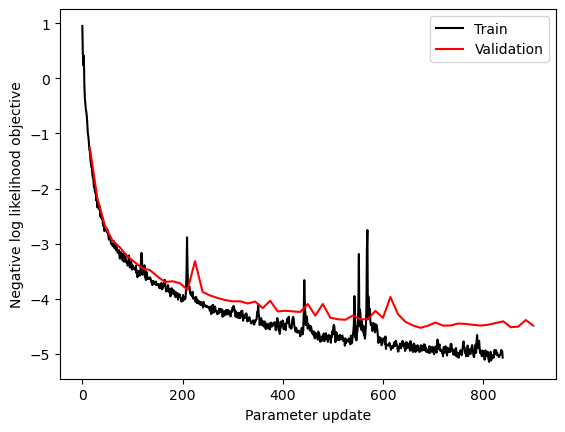

PyObject <matplotlib.legend.Legend object at 0x2979ff220>

In [21]:
fig = figure()
plot(loss_train;label="Train",color="black"); 
plot(batches:batches:batches*(epochs), loss_val;label="Validation",color="red"); 
xlabel("Parameter update"); ylabel("Negative log likelihood objective") ;
legend()

# Helper function for conditional sampling.  

We basically need to pass white noise through the inverse network that is conditioned on the observation. 

In [22]:
function posterior_sampler(G, y, size_x; device=gpu, num_samples=1, batch_size=16)
    # make samples from posterior for train sample 
    X_dummy = randn(Float32, size_x[1:end-1]...,batch_size) |> device
    Y_repeat = repeat(y |>cpu, 1, 1, 1, batch_size) |> device
    _, Zy_fixed, _ = G.forward(X_dummy, Y_repeat); #needs to set the proper sizes here

    X_post = zeros(Float32, size_x[1:end-1]...,num_samples)
    for i in 1:div(num_samples, batch_size)
      Zx_noise_i = randn(Float32, size_x[1:end-1]...,batch_size)|> device
      X_post[:,:,:, (i-1)*batch_size+1 : i*batch_size] = G.inverse(
          Zx_noise_i,
          Zy_fixed
        ) |> cpu;
  end
  X_post
end


posterior_sampler (generic function with 1 method)

## We first select our validation samples. 

Please play with *ind*. Since the model is amortized, posterior sampling is fast for different unseen observations

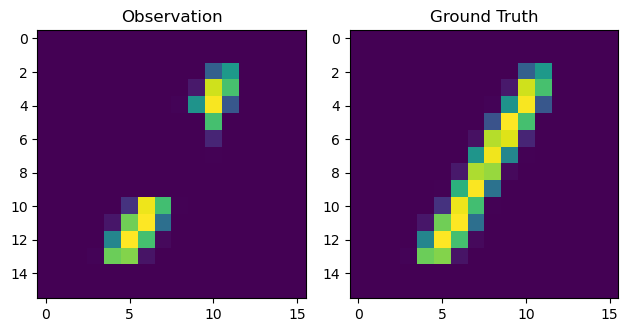

In [26]:
ind = 15
x = XY_val[1][:,:,:,ind:ind]
y = XY_val[2][:,:,:,ind:ind]

figure()
subplot(1,2,1); title("Observation")
imshow(y[:,:,:,1])
subplot(1,2,2); title("Ground Truth")
imshow(x[:,:,:,1])
tight_layout()

# Posterior sampling.  
The cost associated with sampling is low since it requires a single network call. 

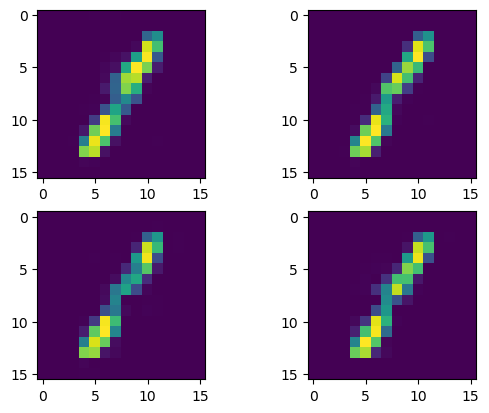

PyObject <matplotlib.image.AxesImage object at 0x2870d9990>

In [27]:
X_post = posterior_sampler(G, y, size(x); device=device, num_samples=64) |> cpu

figure()
subplot(2,2,1)
imshow(X_post[:,:,:,1];vmin=0,vmax=1)
subplot(2,2,2)
imshow(X_post[:,:,:,2];vmin=0,vmax=1)
subplot(2,2,3)
imshow(X_post[:,:,:,3];vmin=0,vmax=1)
subplot(2,2,4)
imshow(X_post[:,:,:,4];vmin=0,vmax=1)


## Using the posterior samples, we can calculate statistics such as pointwise variance and mean. 
In this ill-posed inverse problem there is a clear null-space in the zeroed out portion so we expect high uncertainty there. 

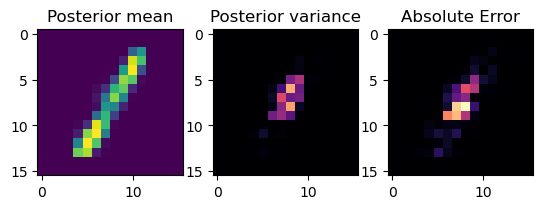

PyObject <matplotlib.image.AxesImage object at 0x297d1cbe0>

In [28]:
X_post_mean = mean(X_post; dims=ndims(X_post))
X_post_var  = var(X_post;  dims=ndims(X_post))

figure()
subplot(1,3,1); title("Posterior mean")
imshow(X_post_mean[:,:,1,1];vmin=0,vmax=1)
subplot(1,3,2); title("Posterior variance")
imshow(X_post_var[:,:,1,1];cmap="magma",vmin=0,vmax=0.1)
subplot(1,3,3); title("Absolute Error")
imshow(abs.(x[:,:,1,1]-X_post_mean[:,:,1,1]);cmap="magma",vmin=0)
